In [56]:
def overlap(a, b, min_length=3):
    """ Return length of longest suffix of 'a' matching
        a prefix of 'b' that is at least 'min_length'
        characters long.  If no such overlap exists,
        return 0. """
    start = 0  # start all the way at the left
    while True:
        start = a.find(b[:min_length], start)  # look for b's prefix in a
        if start == -1:  # no more occurrences to right
            return 0
        # found occurrence; check for full suffix/prefix match
        if b.startswith(a[start:]):
            return len(a)-start
        start += 1  # move just past previous match

In [57]:
def phraseReads(reads, k_mer):
    """
    construct the prefix and suffix of a read to a dictionary with read as
    key and pre-,suffix as values
    """
    reads_dict = {}
    for read in reads:
        for i in range(len(read) - k_mer + 1):
            substring = read[i:i+k_mer]
            if substring not in reads_dict:
                reads_dict[substring] = set([read])
            else:
                reads_dict[substring].add(read)
    return reads_dict    

In [58]:
def bestOverlapFast(reads, k_mer):
    """
    return the reads pair and maxium length of the overlapped pair in reads 
    """
    reads_dict = phraseReads(reads, k_mer)
    read_a, read_b = None, None
    best_overlap = 0
    for read1 in reads:
        k_mer_string = read1[len(read1) - k_mer:]
        if k_mer_string in reads_dict:
            reads_set = reads_dict[k_mer_string]
            for read2 in reads_set:
                if read1 != read2: #skip self comparison
                    offset = overlap(read1, read2, k_mer) 
                    if offset > best_overlap: # skip non-overlapped pairs
                        best_overlap = offset
                        read_a, read_b = read1, read2
    return read_a, read_b, best_overlap

In [59]:
import itertools

def scs(ss):
    """ Returns shortest common superstring of given strings,
        assuming no string is a strict substring of another """
    shortest_sup = None
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]  # superstring starts as first string
        for i in range(len(ss)-1):
            # overlap adjacent strings A and B in the permutation
            olen = overlap(ssperm[i], ssperm[i+1], min_length=1)
            # add non-overlapping portion of B to superstring
            #sup += ssperm[i+1][-(len(ssperm[i+1])-olen):]
            sup += ssperm[i+1][olen:]
        if shortest_sup is None or len(sup) < len(shortest_sup):
            shortest_sup = sup  # found shorter superstring
    return shortest_sup  # return shortest

In [60]:

# This function finds the 2 reads with the maximal overlap, which is the first step in implementing gcs
def pick_maximal_overlap(reads, k):
    """ Return a pair of reads from the list with a
        maximal suffix/prefix overlap >= k.  Returns
        overlap length 0 if there are no such overlaps."""
    reada, readb = None, None
    best_olen = 0
    for a, b in itertools.permutations(reads, 2):
        olen = overlap(a, b, min_length=k)
        if olen > best_olen:
            reada, readb = a, b
            best_olen = olen
    return reada, readb, best_olen  #return the two reads with the best overlap, along with the length




def overlapGraph(self, k_mer):
    """
    construct graph with key as a read (node) and values as all other 
    reads overlapped with the previous read (node)
    """
    reads_dict = self.phraseReads(k_mer)
    reads, _= self.readFastq()
    graph = {}
    for read1 in reads:
        k_mer_string = read1[len(read1) - k_mer:]
        if k_mer_string in reads_dict:
            edges = set([])
            reads_set = reads_dict[k_mer_string]
            for read2 in reads_set:
                if read1 != read2: #skip self comparison
                    offset = self.overlap(read1, read2, k_mer)           
                    if offset > 0: # skip non-overlapped pairs
                        edges.add(read2) #add overlapped reads to be values
                        graph[read1] = edges           
    return graph




In [61]:
def greedy_scs(reads, k):
    """ Greedy shortest-common-superstring merge.
        Repeat until no edges (overlaps of length >= k)
        remain. """
    read_a, read_b, olen = bestOverlapFast(reads, k) 
    while olen > 0:
        reads.remove(read_a) # remove the read a
        reads.remove(read_b) # remove read b
        reads.append(read_a + read_b[olen:])  # add the merged two reads to the list
        read_a, read_b, olen = bestOverlapFast(reads, k)  
    return ''.join(reads)   # return the concatenated reads, then simply merge (if any) reads that are left over

In [62]:
def de_bruijn_ize(st, k):
    """ Return a list holding, for each k-mer, its left
        k-1-mer and its right k-1-mer in a pair """
    edges = []
    nodes = set()
    for i in range(len(st) - k + 1):
        edges.append((st[i:i+k-1], st[i+1:i+k])) # get the L and R k-1 mers
        nodes.add(st[i:i+k-1]) # add the first k-1 mer as a node
        nodes.add(st[i+1:i+k]) # add the second k-1 mer as a node
    return nodes, edges  # re

In [63]:
nodes, edges = de_bruijn_ize("ACGCGTCG", 3)

In [64]:
nodes

{'AC', 'CG', 'GC', 'GT', 'TC'}

In [65]:
edges # this is the Eulerian walk through the graph

[('AC', 'CG'),
 ('CG', 'GC'),
 ('GC', 'CG'),
 ('CG', 'GT'),
 ('GT', 'TC'),
 ('TC', 'CG')]

In [66]:
def visualize_de_bruijn(st, k):
    """ Visualize a directed multigraph using graphviz """
    nodes, edges = de_bruijn_ize(st, k)
    dot_str = 'digraph "DeBruijn graph" {\n'
    for node in nodes:
        dot_str += '  %s [label="%s"] ;\n' % (node, node)
    for src, dst in edges:
        dot_str += '  %s -> %s ;\n' % (src, dst)
    return dot_str + '}\n'

In [67]:
# might have to do this first:
%load_ext gvmagic


The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


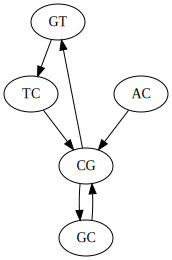

In [68]:
%dotstr visualize_de_bruijn("ACGCGTCG", 3)


Question #1:
It's possible for there to be multiple different shortest common superstrings for the same set of input strings. Consider the input strings ABC\verb|ABC|ABC, BCA\verb|BCA|BCA, CAB\verb|CAB|CAB. One shortest common superstring is ABCAB\verb|ABCAB|ABCAB but another is BCABC\verb|BCABC|BCABC and another is CABCA\verb|CABCA|CABCA.

What is the length of the shortest common superstring of the following strings?

CCT, CTT, TGC, TGG, GAT, ATT

In [69]:
len(scs(['CCT', 'CTT', 'TGC', 'TGG', 'GAT', 'ATT'
]))

11

In [97]:
def scs_track(ss):
    """ Returns shortest common superstring of given strings,
        assuming no string is a strict substring of another """
    shortest_sup = None
    num_ss = 0
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]  # superstring starts as first string
        for i in range(len(ss)-1):
            # overlap adjacent strings A and B in the permutation
            olen = overlap(ssperm[i], ssperm[i+1], min_length=1)
            # add non-overlapping portion of B to superstring
            #sup += ssperm[i+1][-(len(ssperm[i+1])-olen):]
            sup += ssperm[i+1][olen:]
        if shortest_sup is None or len(sup) < len(shortest_sup):
            shortest_sup = sup  # found shorter superstring
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]  # superstring starts as first string
        for j in range(len(ss)-1):
            # overlap adjacent strings A and B in the permutation
            olen = overlap(ssperm[j], ssperm[j+1], min_length=1)
            # add non-overlapping portion of B to superstring
            #sup += ssperm[i+1][-(len(ssperm[i+1])-olen):]
            sup += ssperm[j+1][olen:]
        if len(sup) == len(shortest_sup):
            num_ss = num_ss+1
    return shortest_sup, num_ss  # return shortest

How many different shortest common superstrings are there for the input strings given in the previous question?

Hint 1: You can modify the scs\verb|scs|scs function to keep track of this.

Hint 2: You can look at these examples to double-check that your modified scs\verb|scs|scs is working as expected. 

In [98]:
scs_track(['CCT', 'CTT', 'TGC', 'TGG', 'GAT', 'ATT'
])

('CCTTGGATTGC', 4)

In [99]:
strings = ['ABC', 'BCA', 'CAB']
scs_track(strings)

('ABCAB', 3)

In [101]:
strings2 = ['GAT', 'TAG', 'TCG', 'TGC', 'AAT', 'ATA']
scs_track(strings2)

('TCGATGCAATAG', 10)

Download this FASTQ file containing synthetic sequencing reads from a mystery virus:

https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ads1_week4_reads.fq

All the reads are the same length (100 bases) and are exact copies of substrings from the forward strand of the virus genome. You don't have to worry about sequencing errors, ploidy, or reads coming from the reverse strand.

Assemble these reads using one of the approaches discussed, such as greedy shortest common superstring. Since there are many reads, you might consider ways to make the algorithm faster, such as the one discussed in the programming assignment in the previous module.

How many As are there in the full, assembled genome?

Hint: the virus genome you are assembling is exactly 15,894 bases long


In [47]:
def readFastq(fastq):
    """
    read dna sequence and quality base from a fastq sequencing file to lists
    """
    with open (fastq, "r") as f:
        sequences = []
        qualities = []
        while True:
            f.readline() # skip name line
            seq = f.readline().rstrip() # read sequence line
            f.readline() # skip strand line
            qual = f.readline().rstrip() # read quality line
            if len(seq) == 0: #finish read
                break
            # add seqence and quality information to list
            sequences.append(seq)
            qualities.append(qual)
        f.close()
    return sequences

In [49]:
filename = ("ads1_week4_reads.fq")
virus_reads = readFastq(filename)
genome = greedy_scs(virus_reads,10)


How many Ts are there in the full, assembled genome from the previous question?

In [102]:
def countNt(sequence):
    """count number of each base in a given sequence
    """
    dict_count = {"A":0, "C":0, "G":0, "T":0, "N":0}
    for nt in sequence:
        if nt in dict_count:
            dict_count[nt] = dict_count.get(nt) + 1
        else:
            dict_count[nt] = 1
    return dict_count

In [103]:
print(len(genome))
countNt(genome)

15894


{'A': 4633, 'C': 3789, 'G': 3749, 'T': 3723, 'N': 0}